In [26]:
import numpy as np
import matplotlib.pyplot as plt
from tick.hawkes import HawkesKernelPowerLaw, SimuHawkes, HawkesKernelTimeFunc
from tick.base import TimeFunction

A=[]
B=[]
A_grad=[]
B_grad=[]
tseriesA = np.array([])
epsilon = 1e-8
#delta=1
#alpha=1
#beta=4
#mu=0.05
Dict={}
Dict_gradient={}
Dict_integrate={}
#power kernel = alpha*(delta+t)^(-beta)

#simulation part
#removed
    
def inflectionPoints():
   
    div = B[0]+epsilon*(np.abs(B[0])<epsilon)
    x = -B[1]/div
    interestX1 = x*(x>0)
    alwaysInclude = (x<=0)*(B[0]>0) #dont change
    alwaysExclude = (x<=0)*(B[0]<0)
    tempX = x*(~alwaysInclude)*(~alwaysExclude)
    interestX1 = tempX[interestX1>0]
    interestX = np.sort(interestX1)
    interestX = np.append(0,interestX)
    
    Dict['inflection'] = interestX
   
    con = A[0]*B[0]
    Dict['constant'] = con
    return

def loglikelihood(para):
    alpha=para[0]
    beta =para[1]
    mu=para[2]
    
    tend = t[-1]-t
    
    ll= mu*t[-1]+(alpha/beta)*len(t)
    ll2 = np.sum(-(alpha/beta)*np.exp(-beta*tend))
    ll = ll+ll2-np.log(mu)
    print('exp',ll,(alpha/beta)*len(t))
    for i in range(2,len(t)+1,1):
        li = max(i-10,0)
        temp = t[i-1]-t[li:i-1]
        
        logLam = -np.log(mu+np.sum(alpha*np.exp(-beta*temp)))
        ll = ll+logLam
    return ll

def loglikelihood_rect(para):
    alpha=para[0]
    beta =para[1]
    delta = para[2]
    mu=para[3]
    
   
    
    tend = t[-1]-t
    condition1 = (tend>(delta+1/beta))
    condition2 = (tend>delta)*(tend<(delta+1/beta))
    ll= mu*t[-1]
    ll2 = np.sum(alpha*(condition1)+alpha*beta*(tend-delta)*(condition2))
    ll = ll+ll2-np.log(mu)
    llinit=ll
   
    for i in range(2,len(t)+1,1):
        li = max(i-10,0)*0
        temp = t[i-1]-t[li:i-1]
        
        logLam = -np.log(mu+np.sum(alpha*beta*((temp>delta)*(temp<(delta+1/beta)))))
        ll = ll+logLam
    print('rect',ll2,llinit+np.log(mu), ll-llinit-np.log(mu))
    return ll

def gradientll(para,iArray):
    alpha=para[0]
    beta =para[1]
    mu=para[2]
    tend = t[-1]-t
    grad = np.array([0.0, 0.0, 0.0])
    for i  in np.nditer(iArray):
        li = max(i-50,0)
        temp = t[i]-t[li:i]
        decayFactor = sum(np.exp(-beta*temp))
        lam = mu+alpha*decayFactor
        fac1 = np.exp(-beta*tend[i])
        fac2 = (alpha/beta)*(-(1/beta)+fac1*((1/beta)+tend[i]))
        fac3 = (alpha/lam)*(sum(temp*np.exp(-beta*temp)))+fac2
        grad[0] = grad[0]+(1/beta)*(1-fac1)-(1/lam)*decayFactor
        grad[1]= grad[1]+fac3
        grad[2] = grad[2]+ ((t[i]-t[i-1])-(1/lam))*(i >0)
        
       
        
        
    return grad/len(iArray)

def sgdHawkes(para):
    alpha=para[0]
    beta =para[1]
    mu=para[2]
    lr =0.01
    beta_1 = 0.9
    beta_2 =0.999
    epsilon = 1e-8
    count = 0
    bestll = 1e8
    bestpara = np.array([0.,0.,0.])
    m_t = np.array([0.,0.,0.])
    v_t = np.array([0.,0.,0.])
    for epochs in range(1,30,1):
        
        rsample = np.random.choice(len(t),len(t)-1,replace = False)
        for i in range(1,len(rsample),50):
            count=count+1 
            grad = gradientll(para,rsample[i:i+50])
            m_t = beta_1*m_t + (1-beta_1)*grad	#updates the moving averages of the gradient
            v_t = beta_2*v_t + (1-beta_2)*(grad*grad)	#updates the moving averages of the squared gradient
            m_cap = m_t/(1-(beta_1**count))		#calculates the bias-corrected estimates
            v_cap = v_t/(1-(beta_2**count))		#calculates the bias-corrected estimates
            para = para-(lr*m_cap)/(np.sqrt(v_cap)+epsilon)
            
            error=loglikelihood(para)
            bestpara = para*(bestll>=error)+bestpara*(bestll<error)
            para = np.maximum(para,0)
            bestll = min(bestll,error)
            
            print(i,error,bestll,para,bestpara)   #iteration, -loglikelihood, bestloglik, currentpara, bestpara  
    

def sigmoid(x):                                        
    return 1 / (1 + np.exp(-x))

def softplus(x):
    return np.log1p(np.exp(-np.abs(x))) + np.maximum(x, 0)
    
def nnIntegratedKernel(x):
    x = x.reshape(-1)
    alphas = A[0]
    alpha0 = A[1]
    betas = B[0]
    beta0 = B[1]
    const1 = Dict.get('constant')
    interestX = Dict.get('inflection')
    precalculate_integrate()
    
    y = np.zeros([1,len(x)])
    
    for i in range(0,len(x)):
        xi = x[i]
        if(xi>0):
            iP = max(interestX[interestX<xi])
            n1 = betas*(xi-epsilon) + beta0
            dn1 = (n1>0)
            const =np.dot(const1.T,dn1)
            
            
            term1 = nnKernel(xi)*((const!=0)+xi*(const==0))
            term2 = nnKernel(iP)*((const!=0)+iP*(const==0))
            
            const = (const)*(const!=0)+(const==0)*1.0
            
            prev_term = Dict_integrate.get(iP)
            
            y[0,i] = prev_term + ((term1-term2)/(const))
        
       
               

    return y

def nnKernel(x):
    alphas = A[0]
    alpha0 = A[1]
    betas = B[0]
    beta0 = B[1]
    n1 = np.maximum(np.dot(betas,x) + beta0,0.)
    y = np.dot(alphas.T,n1) + alpha0
    
    y = np.exp(y)
    return y    


def initializeParams(nNeurons):
    alphas = -(np.random.uniform(0,1,nNeurons)).reshape(-1,1)*0.5
    alpha0 = -np.random.uniform(0,1,1)*0.5
    betas = (np.random.uniform(0,1,nNeurons)).reshape(-1,1)*0.5
    beta0 = np.random.uniform(0,1,nNeurons).reshape(-1,1)*0.05
    mu =np.random.uniform(0,1,1)
    
    A.append(alphas)
    B.append(betas)
    A.append(alpha0)
    B.append(beta0)
    A_grad.append(np.zeros([nNeurons,1]))
    A_grad.append(0)
    B_grad.append(np.zeros([nNeurons,1]))
    B_grad.append(np.zeros([nNeurons,1]))
    return mu

def precalculate_integrate():
    alphas = A[0]
    alpha0 = A[1]
    betas = B[0]
    beta0 = B[1]
    iP = Dict.get('inflection')
    const1 = Dict.get('constant')
    Dict_integrate.clear()
    Dict_integrate[0]=0
    y = 0
    for index in range(1,len(iP)):
        n1 = betas*(iP[index]-epsilon) + beta0
        dn1 = (n1>0)
        const =np.dot(const1.T,dn1)
            
            
        term1 = nnKernel(iP[index])*((const!=0)+iP[index]*(const==0))
        term2 = nnKernel(iP[index-1])*((const!=0)+iP[index-1]*(const==0))
            
        const = (const)*(const!=0)+(const==0)*1.0
              
        y= y + ((term1-term2)/(const))
        Dict_integrate[iP[index]]=y
    
    
def precalculate_gradient():
    alphas = A[0]
    alpha0 = A[1]
    betas = B[0]
    beta0 = B[1]
    gradA = alphas*0
    gradB1 = gradA
    gradB0 = gradB1
    gradA0=0
    iP = Dict.get('inflection')
    
    const1 = Dict.get('constant')
    Dict_gradient.clear()
    Dict_gradient[0]=list([gradA0,gradA,gradB1,gradB0])
    for index in range(1,len(iP)):
            
            n0pr = betas*(iP[index-1]+epsilon)+beta0
            n1pr = betas*(iP[index]-epsilon) + beta0
            dn1 = (n1pr>0)
            dn0 = (n0pr>0)
            const =np.dot(const1.T,dn1)
            indicator = const==0
            const = const*(const!=0)+1*(const==0)
            n0 = betas*(iP[index-1])+beta0
            n1 = betas*(iP[index]) + beta0
            
            fac1 = nnKernel(iP[index])
            fac2 = nnKernel(iP[index-1])
            gradA0 = gradA0 + ((1/const)*(fac1-fac2))*(~indicator)+(fac1)*(indicator)*(iP[index]-iP[index-1])
            gradA = gradA -((1/(const*const))*(betas*dn1)*(fac1-fac2))*(~indicator)
            gradA = gradA + ((1/const)*(fac1*np.maximum(n1,0)-fac2*np.maximum(n0,0)))*(~indicator)
            gradB1 = gradB1 -((1/(const*const))*(alphas*dn1)*(fac1-fac2))*(~indicator)
            gradB1 = gradB1 + ((1/const)*(alphas)*(fac1*iP[index]*dn1-fac2*iP[index-1]*dn0))*(~indicator)
            gradB0 = gradB0+ ((1/const)*((alphas)*(fac1*np.maximum(n1,0)-fac2*np.maximum(n0,0))))*(~indicator)
            Dict_gradient[iP[index]]= list([gradA0,gradA,gradB1,gradB0])
    
    return
        
            
         
    
def gradientNetwork(iArray,mu):
    alphas = A[0]
    alpha0 = A[1]
    betas = B[0]
    beta0 = B[1]
    precalculate_gradient()
    tend = t[-1]-t
    x = tend[iArray]
    const1 = Dict.get('constant')
    gradA = alphas*0
    gradB1 = gradA
    gradB0 = gradB1
    gradA0=0
    grad_mu = 0
    
    interestX = Dict.get('inflection')
    temp = 0
    for xi in np.nditer(x):
        if(xi>0):
            iP = max(interestX[interestX<xi])
            n1pr = betas*(xi-epsilon) + beta0
            n0pr = betas*(iP+epsilon)+beta0
           
            dn1 = (n1pr>0)
            dn0 = (n0pr>0)
            const =np.dot(const1.T,dn1)
            indicator = const==0
            const = const*(const!=0)+1*(const==0)
            n0 = betas*(iP)+beta0
            n1 = betas*(xi) + beta0
            fac1 = nnKernel(xi)
            fac2 = nnKernel(iP)
            gradients = Dict_gradient.get(iP)
            
            
            gradA0 = gradA0+gradients[0] + ((1/const)*(fac1-fac2))*(~indicator)+(fac1)*(indicator)*(xi-iP)
            
            gradA = gradA + gradients[1] -((1/(const*const))*(betas*dn1)*(fac1-fac2))*(~indicator)
            gradA = gradA + ((1/const)*(fac1*np.maximum(n1,0)-fac2*np.maximum(n0,0)))*(~indicator)
            
            gradB1 = gradB1+gradients[2] -((1/(const*const))*(alphas*dn1)*(fac1-fac2))*(~indicator)
            gradB1 = gradB1+ ((1/const)*(alphas)*(fac1*xi*dn1-fac2*iP*dn0))*(~indicator)
    
            gradB0 =gradB0+ gradients[3] + ((1/const)*((alphas)*(fac1*np.maximum(n1,0)-fac2*np.maximum(n0,0))))*(~indicator)
        
         
    for i in np.nditer(iArray):
        li = max(i-40,0)
        temp = t[i]-t[li:i]
        fac1 = nnKernel(temp.reshape(1,-1))
        decayFactor = np.sum(fac1)
        lam = mu+decayFactor
        invLam = (1/lam)
        n1 = np.dot(betas,temp.reshape(1,-1)) + beta0
        gradA = gradA-np.sum(invLam*(fac1*np.maximum(n1,0)),axis=1).reshape(-1,1)
        
        gradA0 = gradA0 - invLam*decayFactor
        
        gradB1 = gradB1 - invLam*np.sum(fac1*(n1>0)*alphas*temp.reshape(1,-1),axis=1).reshape(-1,1)
        gradB0 = gradB0 - invLam*np.sum(fac1*(n1>0)*alphas,axis=1).reshape(-1,1)
        grad_mu = grad_mu + ((t[i]-t[i-1])-invLam)*(i >0)
        
    gradA = gradA/len(iArray)
    gradB1 = gradB1/len(iArray)
    gradB0 = gradB0/len(iArray)
    gradA0 = gradA0/len(iArray)
    A_grad[0] = gradA
    A_grad[1] = gradA0
    B_grad[0] = gradB1
    B_grad[1] = gradB0
    return (grad_mu/len(iArray))




def plotKernels():
   
    
    dx=0.01
    tk = np.arange(0,5,dx)
    interestX = Dict.get('inflection')
    
    plt.plot(tk,nnKernel(tk.reshape(1,-1)).reshape(-1,1),'r--')

    
    

    ytemp = nnKernel(tk.reshape(1,-1))
    intYtemp = np.cumsum(ytemp*dx)


    plt.plot(tk,intYtemp.reshape(-1,1),'k--')
    plt.plot(tk,nnIntegratedKernel(tk.reshape(1,-1)).reshape(-1,1),'r--')

    plt.grid()
    plt.pause(0.0005)
    
    return 0

def nnLoglikelihood(mu):
    
    
    tend = (t[-1]-t)
    a = np.sum(nnIntegratedKernel(tend.reshape(1,-1)))
    print(a)
   
    ll = mu*t[-1]+a
    ll = ll-np.log(mu)
    llInit = ll+np.log(mu)
    
    nElements = max(t.shape)
    
    
    for i in range(2,nElements+1,1):
        li = max(i-40,0)
        temp = t[i-1]-t[li:i-1]
        
        z = np.sum(nnKernel(temp.reshape(1,-1)))
        
        
        logLam = -np.log(mu+z)
        
        ll = ll+logLam
    #print('nn',a,llInit,ll-llInit-np.log(mu))
    return ll


 
def sgdNeuralHawkes(nEpochs,lr,mu):
    
    lr2 =lr*0.1
    lr_mu = lr*0.1
    beta_1 = 0.9
    beta_2 =0.999
  
    
    bestll = 1e8
    neg_ll = []
    
    m_t_A = np.zeros([nNeurons,1])
    m_t_A0 =0
    m_t_B= np.zeros([nNeurons,1])
    m_t_B0= np.zeros([nNeurons,1])
    m_t = 0
    v_t_A = np.zeros([nNeurons,1])
    v_t_A0 =0
    v_t_B= np.zeros([nNeurons,1])
    v_t_B0= np.zeros([nNeurons,1])
    v_t = 0
    count = 0
    for epochs in range(1,nEpochs+1,1):
        
        inflectionPoints()
           
        rsample = np.random.choice(len(t),len(t)-1,replace = False)
        for i in range(1,len(rsample),20):
            count=count+1 
            
            grad = gradientNetwork(rsample[i:i+20],mu)
            
            m_t = beta_1*m_t + (1-beta_1)*grad	#updates the moving averages of the gradient
            v_t = beta_2*v_t + (1-beta_2)*(grad*grad)	#updates the moving averages of the squared gradient
            m_cap = m_t/(1-(beta_1**count))		#calculates the bias-corrected estimates
            v_cap = v_t/(1-(beta_2**count))		#calculates the bias-corrected estimates
            mu = mu-(lr_mu*m_cap)/(np.sqrt(v_cap)+epsilon)
            mu = np.maximum(mu,0)
        
            
            m_t_A = beta_1*m_t_A + (1-beta_1)*A_grad[0]	#updates the moving averages of the gradient
            v_t_A = beta_2*v_t_A + (1-beta_2)*(A_grad[0]*A_grad[0])	#updates the moving averages of the squared gradient
            m_cap_A = m_t_A/(1-(beta_1**count))		#calculates the bias-corrected estimates
            v_cap_A = v_t_A/(1-(beta_2**count))		#calculates the bias-corrected estimates
            A[0] = A[0]-(lr*m_cap_A)/(np.sqrt(v_cap_A)+epsilon)
            
            
            m_t_A0 = beta_1*m_t_A0 + (1-beta_1)*A_grad[1]	#updates the moving averages of the gradient
            v_t_A0 = beta_2*v_t_A0 + (1-beta_2)*(A_grad[1]*A_grad[1])	#updates the moving averages of the squared gradient
            m_cap_A0 = m_t_A0/(1-(beta_1**count))		#calculates the bias-corrected estimates
            v_cap_A0 = v_t_A0/(1-(beta_2**count))		#calculates the bias-corrected estimates
            A[1] = A[1]-(lr*m_cap_A0)/(np.sqrt(v_cap_A0)+epsilon)
            
                
            m_t_B = beta_1*m_t_B + (1-beta_1)*B_grad[0]	#updates the moving averages of the gradient
            v_t_B = beta_2*v_t_B + (1-beta_2)*(B_grad[0]*B_grad[0])	#updates the moving averages of the squared gradient
            m_cap_B = m_t_B/(1-(beta_1**count))		#calculates the bias-corrected estimates
            v_cap_B= v_t_B/(1-(beta_2**count))		#calculates the bias-corrected estimates
            B[0] = B[0]-(lr2*m_cap_B)/(np.sqrt(v_cap_B)+epsilon)
            
            
            m_t_B0 = beta_1*m_t_B0 + (1-beta_1)*B_grad[1]	#updates the moving averages of the gradient
            v_t_B0 = beta_2*v_t_B0 + (1-beta_2)*(B_grad[1]*B_grad[1])	#updates the moving averages of the squared gradient
            m_cap_B0 = m_t_B0/(1-(beta_1**count))		#calculates the bias-corrected estimates
            v_cap_B0 = v_t_B0/(1-(beta_2**count))		#calculates the bias-corrected estimates
            B[1] = B[1]-(lr2*m_cap_B0)/(np.sqrt(v_cap_B0)+epsilon)
          
            inflectionPoints()
            
        error=nnLoglikelihood(mu)
        neg_ll.append(error)
        #bestpara = para*(bestll>=error)+bestpara*(bestll<error)
            
        if(bestll > error):
            A0 = np.array(A[0])
            A1 =np.array(A[1])
            B0 = np.array(B[0])
            B1= np.array(B[1])
            optimalParams=list([A0,A1,B0,B1,mu])
               
            
        bestll = min(bestll,error)
        print(i,epochs,bestll,error,mu)   #iteration, -loglikelihood, bestloglik, currentpara, bestpara
            
            
        #plotKernels()
    return optimalParams, neg_ll, nEpochs

In [2]:
import pandas as pd
import numpy as np

url = "https://raw.githubusercontent.com/lekhapriya/SNH/master/Combined.csv"
dataset = pd.read_csv(url, names=['Timestamp', 'Price','Volume','Buyer ID','Seller ID','Buyer is market maker'])
dataset = dataset.sort_values(dataset.columns[0])

orderType = 0  #0--->sell, 1--->buy

if(orderType == 0):
    result_df = dataset.loc[dataset.iloc[:,5]]
    result = result_df.drop_duplicates(subset=['Seller ID'])
elif(orderType == 1):
    result_df = dataset.loc[~dataset.iloc[:,5]]
    result = result_df.drop_duplicates(subset=['Buyer ID'])

#ms to seconds
utc = (result.iloc[:,0].values)/1000

#convert utc to seconds since t0
t_ms = []
for i in range(0,len(utc)) :
    t_ms.append(utc[i]-utc[0])
    
timestamp = np.array(t_ms)
print('N =',len(timestamp))

N = 46946


In [27]:
nNeurons=100
t=timestamp.reshape(-1)
x = initializeParams(nNeurons)

inflectionPoints()

SGD = sgdNeuralHawkes(30,0.01,0.90580107)

26991.421848598533
46941 1 -22318.36448037498 -22318.36448037498 1.302327098551823
26411.711951684607
46941 2 -22831.850209039894 -22831.850209039894 1.4245323103841712
28347.761178021767
46941 3 -22915.921928961394 -22915.921928961394 1.3743568201721659
27297.338152746153
46941 4 -23119.362894980073 -23119.362894980073 1.3174969222983053
24915.81957399792
46941 5 -23119.362894980073 -23051.10163562204 1.2868980624150794
28789.006870083984
46941 7 -23507.352297801175 -23507.352297801175 1.1949379238859432
29335.481022618376
46941 8 -23696.333857274643 -23696.333857274643 1.1773940124778337
28596.405934132847
46941 9 -23760.409429313742 -23760.409429313742 1.1693201058796543
31637.523830790895
46941 10 -23867.651587252134 -23867.651587252134 1.1706154514763476
32128.655309157566
46941 11 -23896.24715817839 -23896.24715817839 1.149202605523718
28618.024253994667
46941 12 -24006.57377245941 -24006.57377245941 1.1820784730918077
28804.853873825938
46941 13 -24006.57377245941 -23968.1219205

In [28]:
def nnOptimalKernel(x):
    optimalParams = SGD[0]
    alphas = optimalParams[0].reshape(-1,1)
    alpha0 = optimalParams[1].reshape(-1,1)
    betas = optimalParams[2].reshape(-1,1)
    beta0 = optimalParams[3].reshape(-1,1)
    n1 = np.maximum(np.dot(betas,x) + beta0,0.)
    y = np.dot(alphas.T,n1) + alpha0
    
    y = np.exp(y)
    return y  
def customIntegrateKernel():
    dx=0.001
    tk = np.arange(0,5,dx)
    
    tend = (t[-1]-t)
    
    t2 = np.unique(np.concatenate([tend, tk]))
    
    
    t3 = np.sort(t2)
    
    dx = np.diff(t3)
    
    ytemp = nnOptimalKernel(t3.reshape(1,-1)).reshape(-1)
    yTrap= 0.5*(ytemp[0:-1]+ytemp[1:])
    
    a = np.multiply(yTrap,dx)
    
    a1 = np.cumsum(np.concatenate([np.array([0]), a]).reshape(-1))
    
    
    
    b = a1[[np.where(t3 ==x)[0][0] for x in tend]]
   
    
    return b

def SNH_Neg_LL():
    optimalParams = SGD[0]
    mu = optimalParams[4]
    
    
    tend = (t[-1]-t)
    
    a = np.sum(customIntegrateKernel())
    print(a)
   
    ll = mu*t[-1]+a
    ll = ll-np.log(mu)
    llInit = ll+np.log(mu)
    
    nElements = max(t.shape)
        
    for i in range(2,nElements+1,1):
        li = max(i-40,0)
        temp = t[i-1]-t[li:i-1]      
        z = np.sum(nnOptimalKernel(temp.reshape(1,-1)))               
        logLam = -np.log(mu+z)        
        ll = ll+logLam
    return ll
    

In [5]:
n_ll = []

In [20]:
neg_logl = SNH_Neg_LL()
n_ll.append(neg_logl)
print(n_ll)

28048.982124062797
[-18635.35052736376, -25999.208452026505, -26036.827662241532, -25795.665676517703, -24662.490698049354]


In [29]:

from tick.hawkes import HawkesEM, HawkesConditionalLaw,HawkesSumExpKern

#support = 1000
em = HawkesEM(kernel_support = 6, kernel_size=100, n_threads=4, verbose=False, tol=1e-4)
wh = HawkesConditionalLaw(n_quad=200)
#wh = HawkesConditionalLaw(claw_method="log", delta_lag=0.1, min_lag=0.002,
#                         max_lag=100, quad_method="log", n_quad=100,
#                         min_support=0.002, max_support=support, n_threads=-1)


timestamp = timestamp.astype('float64') 
h_time = [timestamp]

em.fit(h_time)
#wh.fit(h_time)
wh.incremental_fit(h_time)
wh.compute()

mu_SNH = 1.1471051471821234 mu_EM = [0.78118631] mu_WH = [0.29054226]


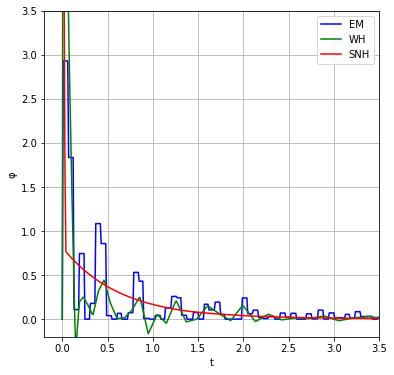

In [30]:


#to learn mu
optimalParams = SGD[0]
print('mu_SNH =',optimalParams[4],'mu_EM =', em.baseline,'mu_WH =',wh.baseline)

#checking the attributes
c_nodes = em.n_nodes

dx=0.01
tk = np.arange(0,5,dx)

fig, axs = plt.subplots(c_nodes,c_nodes, sharex=True,
                                         sharey=True,figsize=(6, 6))

    
ax_list_list = np.array([[axs]])

for i, ax_list in enumerate(ax_list_list):
    for j, ax in enumerate(ax_list):
        y_values = em.get_kernel_values(i, j, tk)
        ax.plot(tk, y_values,'b-', label='EM')
        y_values = wh.get_kernel_values(i, j, tk)
        ax.plot(tk, y_values,'g-', label='WH')

axs.plot(tk,nnKernel(tk.reshape(1,-1)).reshape(-1,1),'r-', label = 'SNH')
axs.grid()
plt.legend(fontsize=10)
#plt.title('Buy order lr2 = 5X10^-5')
plt.xlabel('t')
plt.ylabel('\u03C6')
plt.axis([-0.2, 3.5, -0.2,3.5])
#plt.tight_layout()
plt.savefig("1D_binance_kernel_sell.png")


In [31]:
#to calculate Neg_ll of EM

def customIntegrateKernelEM():
    dx=0.001
    tk = np.arange(0,5,dx)
    tend = (t[-1]-t)
    t2 = np.unique(np.concatenate([tend, tk]))
    t3 = np.sort(t2)
    dx = np.diff(t3)
    ytemp = em.get_kernel_values(0,0,t3.reshape(1,-1)).reshape(-1)
    yTrap= 0.5*(ytemp[0:-1]+ytemp[1:])
    a = np.multiply(yTrap,dx)
    a1 = np.cumsum(np.concatenate([np.array([0]), a]).reshape(-1))
    b = a1[[np.where(t3 ==x)[0][0] for x in tend]]
    return b

def EM_Neg_ll():
    mu = em.baseline
    a = np.sum(customIntegrateKernelEM())
    ll = mu*t[-1]+a
    ll = ll-np.log(mu)
    llInit = ll+np.log(mu)
    nElements = max(t.shape)
    for i in range(2,nElements+1,1):
        li = max(i-40,0)
        temp = t[i-1]-t[li:i-1]        
        z = np.sum(em.get_kernel_values(0,0,temp))
        logLam = -np.log(mu+z)        
        ll = ll+logLam
    return ll

In [32]:
print(EM_Neg_ll())

[-22262.44952319]


In [35]:
def customIntegrateKernelWH():
    dx=0.001
    tk = np.arange(0,5,dx)
    
    tend = (t[-1]-t)
    
    t2 = np.unique(np.concatenate([tend, tk]))
    
    
    t3 = np.sort(t2)
    
    dx = np.diff(t3)
    
    ytemp = wh.get_kernel_values(0,0,t3.reshape(1,-1)).reshape(-1)
    ytemp[ytemp < 0] = 0
    yTrap= 0.5*(ytemp[0:-1]+ytemp[1:])
    
    a = np.multiply(yTrap,dx)
    
    a1 = np.cumsum(np.concatenate([np.array([0]), a]).reshape(-1))
    
    
    
    b = a1[[np.where(t3 ==x)[0][0] for x in tend]]
   
    
    return b
def WH_Neg_ll():
    mu = wh.baseline
    
    a = np.sum(customIntegrateKernelWH())
   
    ll = mu*t[-1]+a
    ll = ll-np.log(mu)
    llInit = ll+np.log(mu)
    
    nElements = max(t.shape)
    
    for i in range(2,nElements+1,1):
        li = max(i-40,0)
        temp = t[i-1]-t[li:i-1]        
        temp2 = wh.get_kernel_values(0,0,temp)
        temp2[temp2 < 0] = 0
        z = np.sum(temp2)
        logLam = -np.log(mu+z)        
        ll = ll+logLam
    return ll

In [36]:
print(WH_Neg_ll())

[-7518.8367809]


In [ ]:
negll = SGD[1]
plt.plot(range(0,len(negll)),negll,'k-')
min(negll)
#print(yu)


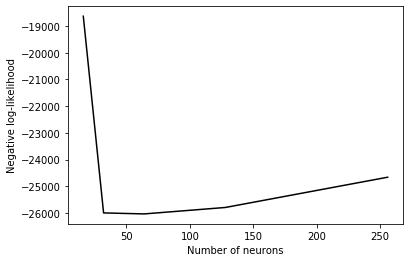

In [24]:
t_val = np.array([16,32,64,128,256])
y_val = np.array(n_ll)
plt.plot(t_val,y_val,'k-')
plt.xlabel('Number of neurons')
plt.ylabel('Negative log-likelihood')
plt.savefig("no. of neuron vs neg ll.png")